In [ ]:
import zipfile
import requests
import random
import os
from time import strftime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools as it

import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras import backend as K


from keras import regularizers
from keras.utils import to_categorical

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances

from scipy.sparse import csr_matrix
from scipy.stats import pearsonr

#### **Getting data**

In [ ]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
zip_name = 'ml-100k.zip'
data_dir = 'ml-100k/'

r = requests.get(url, allow_redirects=True)
open(zip_name, 'wb').write(r.content)

with zipfile.ZipFile(zip_name,"r") as zip_ref:
    zip_ref.extractall()

# Columns Names
cols_data = ['user_id','item_id','rating','timestamp']
cols_user = ['user_id','age','gender','occupation','zip code']
cols_item = ['movie_id','movie_title','release_date','video_release_date','IMDb_URL','unknown', 'Action', 'Adventure', 
                'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
                'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
cols_genre = ['genre_name', 'genre_id']
cols_occupation = ['occupation']

# Read users data file
df_users = pd.read_csv(data_dir + 'u.user',delimiter='|', header=None,names=cols_user, index_col='user_id')

# Read items(movies) data file
df_items = pd.read_csv(data_dir + 'u.item',delimiter='|', header=None,names=cols_item,encoding="ISO-8859-1", index_col='movie_id')

# Read rating data file
df_ratings = pd.read_csv(data_dir + 'u.data',delimiter='\t', header=None,names=cols_data)

# Read genres data file
df_genres = pd.read_csv(data_dir + 'u.genre',delimiter='|', header=None,names=cols_genre, index_col='genre_id')

# Read occupation data file
df_occupation = pd.read_csv(data_dir + 'u.occupation',delimiter='|', header=None,names=cols_occupation)

# Gender dataframe
df_gender = pd.DataFrame(['M', 'F'], columns=['Gender'])

In [ ]:
df_users.head()

,age,gender,occupation,zip code
user_id,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213


In [ ]:
df_items.head()

,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
df_ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
df_genres.head()

,genre_name
genre_id,
0,unknown
1,Action
2,Adventure
3,Animation
4,Children's


In [ ]:
df_occupation.head()

,occupation
0,administrator
1,artist
2,doctor
3,educator
4,engineer


#### **Preprocessesing data**

In [ ]:
df_items['release_date'] = pd.to_datetime(df_items['release_date'], format='%d-%b-%Y') #Convert to the same format as rating_date

# Convert timestamp to date
df_ratings['rating_date'] = pd.to_datetime(df_ratings['timestamp'], unit='s')
df_ratings.drop(columns=['timestamp'], inplace=True)

# In the paper they are using implicit feedback. to mimic that I'll change the rating to be binary
df_ratings['rating_binary'] = (df_ratings['rating'] >= 3).astype(int)

# Create ratings
ratings = df_ratings.pivot(index = 'user_id', columns ='item_id', values = 'rating_binary').fillna(0)

##### **One Hot vector**

###### **Gender**

In [ ]:
# Using np.eye to generate one hot vector
df_users['one_hot_gender'] = df_users['gender'].apply(lambda x: df_gender[df_gender['Gender'] == x].index[0])
df_users['one_hot_gender'] = df_users['one_hot_gender'].apply(lambda x: np.eye(len(df_gender.index))[x]) 
df_users.head()

,age,gender,occupation,zip code,one_hot_gender
user_id,,,,,
1,24,M,technician,85711,"[1.0, 0.0]"
2,53,F,other,94043,"[0.0, 1.0]"
3,23,M,writer,32067,"[1.0, 0.0]"
4,24,M,technician,43537,"[1.0, 0.0]"
5,33,F,other,15213,"[0.0, 1.0]"


###### **Occupation**

In [ ]:
# Using np.eye to generate one hot vector
df_users['one_hot_occupation'] = df_users['occupation'].apply(lambda x: df_occupation[df_occupation['occupation'] == x].index[0])
df_users['one_hot_occupation'] = df_users['one_hot_occupation'].apply(lambda x: np.eye(len(df_occupation.index))[x]) 
df_users.head()

,age,gender,occupation,zip code,one_hot_gender,one_hot_occupation
user_id,,,,,,
1,24,M,technician,85711,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,53,F,other,94043,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,23,M,writer,32067,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,24,M,technician,43537,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,33,F,other,15213,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


###### **ZipCode**

In [ ]:
# The first digit of a zip code represents a group of states, known as a "sector". 
# So I will one hot vector the zipcode by sectors
# Some users has weird zipcode so I will change them to random sector

# Using np.eye to generate one hot vector
df_users['one_hot_zipcode'] = df_users['zip code'].apply(lambda x: np.eye(10)[int(x[0]) if x.isdigit() else random.randint(0, 9)]) # We have 10 secotrs 
df_users.head()

,age,gender,occupation,zip code,one_hot_gender,one_hot_occupation,one_hot_zipcode
user_id,,,,,,,
1,24,M,technician,85711,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
2,53,F,other,94043,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,23,M,writer,32067,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,24,M,technician,43537,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
5,33,F,other,15213,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


##### **Categorical vector**

###### **Genre**

In [ ]:
genres_list = df_genres.genre_name.to_numpy()
df_items['genres_categorical_vector'] = df_items.apply(lambda x: [i for i, v in enumerate(genres_list) if x[v]], axis=1)
df_items.head()

,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genres_categorical_vector
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,"[3, 4, 5]"
2,GoldenEye (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,"[1, 2, 16]"
3,Four Rooms (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,[16]
4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[1, 5, 8]"
5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,"[6, 8, 16]"


##### **Normalize age**

In [ ]:
# Using min-max normalization
df_users['normalize_age'] = (df_users['age'] - df_users['age'].min()) / (df_users['age'].max() - df_users['age'].min())
df_users.head()

,age,gender,occupation,zip code,one_hot_gender,one_hot_occupation,one_hot_zipcode,normalize_age
user_id,,,,,,,,
1,24,M,technician,85711,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0.257576
2,53,F,other,94043,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.696970
3,23,M,writer,32067,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.242424
4,24,M,technician,43537,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.257576
5,33,F,other,15213,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.393939


In [ ]:
# Adding all the user features together
df_users['user_features'] = df_users.apply(lambda row: list(np.concatenate((row['one_hot_gender'], row['one_hot_occupation'], [row['normalize_age']], row['one_hot_zipcode']))), axis=1)
df_users.head()

,age,gender,occupation,zip code,one_hot_gender,one_hot_occupation,one_hot_zipcode,normalize_age,user_features
user_id,,,,,,,,,
1,24,M,technician,85711,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0.257576,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,53,F,other,94043,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.696970,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,23,M,writer,32067,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.242424,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,24,M,technician,43537,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.257576,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,33,F,other,15213,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.393939,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


##### **Example age**

In [ ]:
# Example age = rating_date - release_date of the item
df_ratings['example_age'] = df_ratings.join(df_items[['release_date']], on='item_id', how='left')[['rating_date', 'release_date']].apply(lambda x: float((x['rating_date'] - x['release_date']).days),axis=1)
df_ratings['example_age'] = df_ratings['example_age'].fillna(df_ratings['example_age'].mean()) # Check for NaN 
df_ratings['example_age'] = (df_ratings['example_age'] - df_ratings['example_age'].min()) / (df_ratings['example_age'].max() - df_ratings['example_age'].min()) # min-max normalization
df_ratings.head()

,user_id,item_id,rating,rating_date,rating_binary,example_age
0,196,242,3,1997-12-04 15:55:49,1,0.021556
1,186,302,3,1998-04-04 19:22:22,1,0.026670
2,22,377,1,1997-11-07 07:18:36,0,0.060336
3,244,51,2,1997-11-27 05:02:03,0,0.061046
4,166,346,1,1998-02-02 05:33:16,0,0.024504


##### **KNN**

In [ ]:
def knn_pearson_correlation(features, k=5):

    # Convert it to matrix
    features_matrix = []
    for user in features:
      features_matrix.append(user)

    # Compute pairwise similarity matrix using Pearson correlation coefficient
    pairwise_similarity = pairwise_distances(features_matrix, metric='correlation')
    pairwise_similarity[np.isnan(pairwise_similarity)] = 0

    # Find the k nearest neighbors for each user
    knn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='precomputed')
    knn.fit(pairwise_similarity)
    nn_indices = knn.kneighbors(return_distance=False)

    return nn_indices + 1 # +1 To match users id

In [ ]:
nearest_neighbors = knn_pearson_correlation(df_users.user_features.values, 10)

df_users['nearest_neighbors'] = list(nearest_neighbors) #.astype(np.float32)
df_users['nearest_neighbors'] = df_users['nearest_neighbors'].apply(lambda x: list(x))
df_users.head()

,age,gender,occupation,zip code,one_hot_gender,one_hot_occupation,one_hot_zipcode,normalize_age,user_features,nearest_neighbors
user_id,,,,,,,,,,
1,24,M,technician,85711,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0.257576,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[717, 790, 244, 670, 77, 774, 134, 311, 92, 251]"
2,53,F,other,94043,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.696970,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[885, 732, 342, 751, 423, 591, 454, 810, 696, ..."
3,23,M,writer,32067,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.242424,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[21, 695, 750, 896, 676, 897, 199, 201, 905, 388]"
4,24,M,technician,43537,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.257576,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[44, 77, 670, 440, 578, 724, 871, 483, 193, 219]"
5,33,F,other,15213,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.393939,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[155, 760, 376, 273, 460, 797, 733, 914, 835, ..."


##### **History watch**

In [ ]:
group_user_item = df_ratings \
  .join(df_items[['genres_categorical_vector']], on='item_id', how='inner') \
  .sort_values(by='rating_date') \
  .groupby(['user_id']) \
  .agg({'item_id': list, 'rating_date': list, 'rating_binary': list, 'genres_categorical_vector': list, 'example_age': list})

group_user_item.head()

,item_id,rating_date,rating_binary,genres_categorical_vector,example_age
user_id,,,,,
1,"[168, 172, 165, 156, 166, 196, 187, 250, 14, 1...","[1997-09-22 21:57:58, 1997-09-22 21:57:58, 199...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[5], [1, 2, 8, 14, 15, 17], [8], [6, 16], [8]...","[0.3181220924038496, 0.24031393160268474, 0.16..."
2,"[286, 258, 305, 307, 288, 312, 301, 269, 292, ...","[1998-02-27 03:26:00, 1998-02-27 03:26:01, 199...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","[[8, 14, 17], [8, 15], [8], [6, 11, 13, 16], [...","[0.027060620050427926, 0.01860861536276146, 0...."
3,"[300, 344, 333, 302, 268, 303, 337, 345, 354, ...","[1998-03-07 02:15:39, 1998-03-07 02:15:39, 199...","[0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[[1, 16], [8], [13, 16], [6, 10, 13, 16], [8, ...","[0.025675627685642247, 0.013210696402571115, 0..."
4,"[258, 288, 300, 328, 271, 362, 359, 329, 327, ...","[1998-04-08 02:09:34, 1998-04-08 02:10:45, 199...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[8, 15], [11, 16], [1, 16], [1, 13, 14, 16], ...","[0.020029120352285237, 0.0272381831741184, 0.0..."
5,"[267, 222, 455, 121, 363, 405, 257, 250, 25, 2...","[1997-09-30 15:57:44, 1997-09-30 15:59:34, 199...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","[[0], [1, 2, 15], [1], [1, 15, 17], [1], [1, 2...","[0.1386924915575226, 0.021485137966547108, 0.0..."


In [ ]:
# Got some help from chatGPT for this one :)
window_length = 32

def extract_windows(user_id, item):
    windows = []
    for j in range(len(item['item_id']) - (window_length + 1)):
        item_id = item['item_id'][j:j + window_length]
        ratings = item['rating_binary'][j:j + window_length]
        genres_categorical_vector = item['genres_categorical_vector'][j + window_length]#list(set(it.chain(*item['genres_categorical_vector'][j:j + window_length])))
        positives = list(np.array(item_id)[np.array(ratings, dtype=bool)])
        negatives = list(np.array(item_id)[~np.array(ratings, dtype=bool)])
        next_id = item['item_id'][j + window_length]
        next_id_one_hot = to_categorical(item['item_id'][j + window_length], num_classes=df_items.index.max() + 1)
        next_label = item['rating_binary'][j + window_length]
        example_age = [item['example_age'][j + window_length]]

        window = (
            user_id, item_id, ratings, genres_categorical_vector,
            positives, negatives, next_id, next_id_one_hot, next_label, example_age
        )
        windows.append(window)
    return windows

windows = list(it.chain(*[extract_windows(user_id, item) for user_id, item in group_user_item.iterrows()]))
df_windows = pd.DataFrame(windows, columns=['user_id', 'item_id', 'ratings', 'genres_categorical_vector', 'positives', 'negatives', 'next_id', 'next', 'next_label', 'example_age'])
df_windows.head()

,user_id,item_id,ratings,genres_categorical_vector,positives,negatives,next_id,next,next_label,example_age
0,1,"[168, 172, 165, 156, 166, 196, 187, 250, 14, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[15, 16]","[168, 172, 165, 156, 166, 196, 187, 250, 14, 1...",[],264,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,[0.011577115664618772]
1,1,"[172, 165, 156, 166, 196, 187, 250, 14, 127, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 8, 16, 17]","[172, 165, 156, 166, 196, 187, 250, 14, 127, 1...",[264],245,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,[0.016868496750594836]
2,1,"[165, 156, 166, 196, 187, 250, 14, 127, 181, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[8],"[165, 156, 166, 196, 187, 250, 14, 127, 181, 1...","[264, 245]",126,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,[0.02400653432295181]
3,1,"[156, 166, 196, 187, 250, 14, 127, 181, 117, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 13, 15, 16]","[156, 166, 196, 187, 250, 14, 127, 181, 117, 1...","[264, 245, 126]",260,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,[0.019851557228594767]
4,1,"[166, 196, 187, 250, 14, 127, 181, 117, 109, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[8, 14]","[166, 196, 187, 250, 14, 127, 181, 117, 109, 1...","[264, 245, 126, 260]",237,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,[0.02052629709861856]


In [ ]:
# Adding user_features, nearest_neighbors, gender to the dataframe
df_windows_features = df_windows.join(df_users[['user_features', 'nearest_neighbors', 'gender']], on='user_id')
df_windows_features['gender'] = df_windows_features['gender'].apply(lambda x: 1 if x == 'M' else 0)
df_windows_features.head()

,user_id,item_id,ratings,genres_categorical_vector,positives,negatives,next_id,next,next_label,example_age,user_features,nearest_neighbors,gender
0,1,"[168, 172, 165, 156, 166, 196, 187, 250, 14, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[15, 16]","[168, 172, 165, 156, 166, 196, 187, 250, 14, 1...",[],264,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,[0.011577115664618772],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[717, 790, 244, 670, 77, 774, 134, 311, 92, 251]",1
1,1,"[172, 165, 156, 166, 196, 187, 250, 14, 127, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 8, 16, 17]","[172, 165, 156, 166, 196, 187, 250, 14, 127, 1...",[264],245,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,[0.016868496750594836],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[717, 790, 244, 670, 77, 774, 134, 311, 92, 251]",1
2,1,"[165, 156, 166, 196, 187, 250, 14, 127, 181, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[8],"[165, 156, 166, 196, 187, 250, 14, 127, 181, 1...","[264, 245]",126,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,[0.02400653432295181],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[717, 790, 244, 670, 77, 774, 134, 311, 92, 251]",1
3,1,"[156, 166, 196, 187, 250, 14, 127, 181, 117, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 13, 15, 16]","[156, 166, 196, 187, 250, 14, 127, 181, 117, 1...","[264, 245, 126]",260,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,[0.019851557228594767],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[717, 790, 244, 670, 77, 774, 134, 311, 92, 251]",1
4,1,"[166, 196, 187, 250, 14, 127, 181, 117, 109, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[8, 14]","[166, 196, 187, 250, 14, 127, 181, 117, 109, 1...","[264, 245, 126, 260]",237,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,[0.02052629709861856],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[717, 790, 244, 670, 77, 774, 134, 311, 92, 251]",1


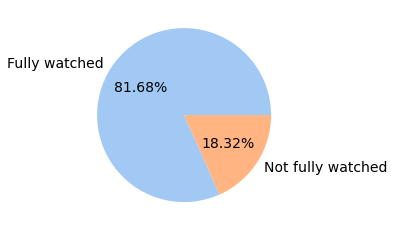

In [ ]:
# Visualizing class representation
class_0 = len(df_windows_features[df_windows_features['next_label'] == 0])
class_1 = len(df_windows_features[df_windows_features['next_label'] == 1])

labels = ['Fully watched', 'Not fully watched']
num_classes = [class_1, class_0]

fig, ax = plt.subplots()
ax.pie(num_classes, labels=labels, autopct='%1.2f%%', textprops={'fontsize':14}, colors=sns.color_palette('pastel'))

plt.show() 

##### **Train/Validation/Test split**

In [ ]:
# For the validation set take the second to last row for each user_id and for the test take the last row 
train_df = df_windows_features.groupby('user_id').apply(lambda x: x.iloc[:-2]).reset_index(drop=True).sample(frac=1)
val_df   = df_windows_features.groupby('user_id').apply(lambda x: x.iloc[-2:-1]).reset_index(drop=True).sample(frac=1)
test_df  = df_windows_features.groupby('user_id').last().sample(frac=1)

#### **Baseline model (Matrix Factorization)**

##### **Model class**

In [ ]:
class Matrix_Factorization_Model(k.models.Model):
    def __init__(self, num_users, num_items, latent_dim):
        super(Matrix_Factorization_Model, self).__init__()

        # create embedding layers for user and item
        self.user_embedding = k.layers.Embedding(input_dim=num_users, output_dim=latent_dim, mask_zero=True, trainable=True, name='user_embedding')
        self.item_embedding = k.layers.Embedding(input_dim=num_items, output_dim=latent_dim, mask_zero=True, trainable=True, name='item_embedding')

    def call(self, inputs):
        # extract user and item indices from inputs
        user_indices, item_indices = inputs

        # get embedding vectors and bias terms for user and item
        user_embedding = self.user_embedding(user_indices)
        item_embedding = self.item_embedding(item_indices)

        outputs = tf.math.multiply(user_embedding, item_embedding)
        outputs = tf.reduce_sum(outputs, axis=1)

        return outputs

##### **Training and hyperparameter tuning**

In [ ]:
history_list_baseline = {}
print('Start Training')

num_users = df_users.index.max() + 1
num_items = df_items.index.max() + 1
latent_dim = 20

# create model instance
model_mf = Matrix_Factorization_Model(num_users, num_items, latent_dim)

# compile model
model_mf.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam()) #, metrics=['acc']

# train model
history = model_mf.fit(
    x=[
        np.int_(train_df['user_id'].values), 
        np.int_(train_df['next_id'].values)
    ], y=np.int_(train_df['next_label'].values),
    validation_data=([
        np.int_(val_df['user_id'].values), 
        np.int_(val_df['next_id'].values)
    ], np.int_(val_df['next_label'].values)),
    callbacks=[
        k.callbacks.TensorBoard(os.path.join("logs", strftime("%Y-%m-%d %H:%M:%S")), histogram_freq=1),
        k.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
    ],
    epochs=20
)

model_mf.save_weights('baseModel.h5')

# Save history
history_list_baseline['Base_line'] = history

Start Training
Epoch 1/20
2169/2169 [==============================] - 6s 3ms/step - loss: 0.4603 - val_loss: 0.2533
Epoch 2/20
2169/2169 [==============================] - 6s 3ms/step - loss: 0.1272 - val_loss: 0.1893
Epoch 3/20
2169/2169 [==============================] - 5s 2ms/step - loss: 0.1125 - val_loss: 0.1687
Epoch 4/20
2169/2169 [==============================] - 6s 3ms/step - loss: 0.1044 - val_loss: 0.1645
Epoch 5/20
2169/2169 [==============================] - 5s 2ms/step - loss: 0.0970 - val_loss: 0.1614
Epoch 6/20
2169/2169 [==============================] - 5s 2ms/step - loss: 0.0900 - val_loss: 0.1596
Epoch 7/20
2169/2169 [==============================] - 5s 2ms/step - loss: 0.0832 - val_loss: 0.1641
Epoch 8/20
2169/2169 [==============================] - 5s 2ms/step - loss: 0.0771 - val_loss: 0.1679


In [ ]:
#model_mf.save_weights('baseModel.h5')
#model_mf.load_weights('baseModel.h5') 

##### **Visualization**

In [ ]:
def plot_learning_curve(history, key):
    fig, axes = plt.subplots(1, 1,figsize=(8,4)) 

    # Extract the training and validation loss from the training history
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot the Loss curve
    axes.plot(loss, label='Training loss')
    axes.plot(val_loss, label='Validation loss')

    axes.set_xlabel('Epochs')
    axes.set_ylabel('Loss')

    axes.legend()
    axes.set_title(f'Loss Curve. Best Training loss: {loss[-1]:.3f}, Val loss: {val_loss[-1]:.3f}')

    fig.suptitle(key, fontsize=16)
    plt.show()

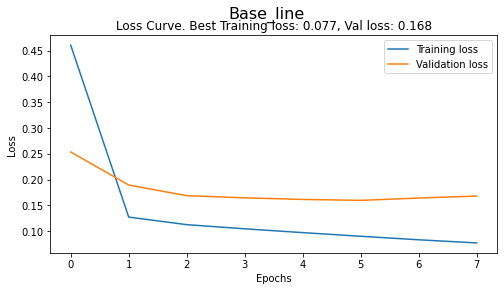

In [ ]:
for key in history_list_baseline.keys():
    plot_learning_curve(history_list_baseline[key], key)

#### **Original Model**

##### **Model class**

In [ ]:
# I needed some help to implement these aggregation layers. Found a similar implementation online and used it.
class MaskedEmbeddingsAggregatorLayer(tf.keras.layers.Layer):
    def __init__(self, agg_mode='sum', **kwargs):
        super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)

        if agg_mode not in ['sum', 'mean', 'none']:
            raise NotImplementedError('mode {} not implemented!'.format(agg_mode))
        self.agg_mode = agg_mode
    
    @tf.function
    def call(self, inputs, mask=None):
        if self.agg_mode == 'sum':
            aggregated =  tf.reduce_sum(inputs, axis=1)
        elif self.agg_mode == 'mean':
            aggregated = tf.reduce_mean(inputs, axis=1)
        elif self.agg_mode == 'none':
            aggregated = inputs
        
        return aggregated
    
    def get_config(self):
        # this is used when loading a saved model that uses a custom layer
        return {'agg_mode': self.agg_mode}

class L2NormLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2NormLayer, self).__init__(**kwargs)
    
    @tf.function
    def call(self, inputs, mask=None):
        if mask is not None:
            inputs = tf.ragged.boolean_mask(inputs, mask).to_tensor()
        return tf.math.l2_normalize(inputs, axis=-1)

In [ ]:
def RankingGeneration(n_items, embedding_dim, learning_rate=1e-3, reg=1e-2):

    # Inputs
    input_genre = k.Input(shape=(None,), name='genre')
    input_item = k.Input(shape=(None,), name='item_id')
    input_positive = k.Input(shape=(None,), name='positive')
    input_negative = k.Input(shape=(None,), name='negative')
    input_example_age = k.Input(shape=(None,), name='example_age')
    input_user_features = k.Input(shape=(None,), name='user_features')
    input_current_item = k.Input(shape=(None, n_items), name='current_item')

    # Embeddings
    features_embedding_layer = k.layers.Embedding(input_dim=n_items, output_dim=embedding_dim, mask_zero=True, trainable=True, name='features_embeddings')
    avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')


    # Fully connected
    dense_1 = k.layers.Dense(1024, name='dense_1', kernel_regularizer=regularizers.l2(reg))
    dense_2 = k.layers.Dense(512, name='dense_2', kernel_regularizer=regularizers.l2(reg))
    dense_3 = k.layers.Dense(256, name='dense_3', kernel_regularizer=regularizers.l2(reg))

    l2_norm_1 = L2NormLayer(name='l2_norm_1')

    dense_output = k.layers.Dense(1, tf.nn.sigmoid, name='dense_output')

    # Features

    # Genre
    genre_embeddings = features_embedding_layer(input_genre)
    l2_norm_genre = l2_norm_1(genre_embeddings)
    avg_genre = avg_embeddings(l2_norm_genre)

    # Ids
    item_embeddings = features_embedding_layer(input_item)
    l2_norm_item = l2_norm_1(item_embeddings)
    avg_item = avg_embeddings(l2_norm_item)

    # Positive
    positive_embeddings = features_embedding_layer(input_positive)
    l2_norm_positive = l2_norm_1(positive_embeddings)
    avg_positive = avg_embeddings(l2_norm_positive)

    # Negative
    negative_embeddings = features_embedding_layer(input_negative)
    l2_norm_negative = l2_norm_1(negative_embeddings)
    avg_negative = avg_embeddings(l2_norm_negative)

    # Example age
    example_age_embeddings = features_embedding_layer(input_example_age)
    l2_norm_example_age = l2_norm_1(example_age_embeddings)
    avg_example_age = avg_embeddings(l2_norm_example_age)

    # User features
    user_features_embeddings = features_embedding_layer(input_user_features)
    l2_norm_user_features = l2_norm_1(user_features_embeddings)
    avg_user_features = avg_embeddings(l2_norm_user_features)

    # User features
    input_current_item = k.backend.sum(input_current_item, axis=1) # To reshape the input

    # Concatenate 
    concat_inputs = k.layers.Concatenate(axis=1)([avg_genre, avg_item, avg_positive, avg_negative, avg_example_age, avg_user_features, input_current_item])
    

    # Dense layers
    # Layer 1
    dense_1_features = dense_1(concat_inputs)
    dense_1_relu = k.layers.ReLU(name='dense_1_relu')(dense_1_features)
    dense_1_batch_norm = k.layers.BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

    # Layer 2
    dense_2_features = dense_2(concat_inputs)
    dense_2_relu = k.layers.ReLU(name='dense_2_relu')(dense_2_features)
    dense_2_batch_norm = k.layers.BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

    # Layer 3
    dense_3_features = dense_3(concat_inputs)
    dense_3_relu = k.layers.ReLU(name='dense_3_relu')(dense_3_features)
    dense_3_batch_norm = k.layers.BatchNormalization(name='dense_3_batch_norm')(dense_3_relu)

    outputs = dense_output(dense_3_batch_norm)

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Model
    model = tf.keras.models.Model(inputs=[input_genre, input_item, input_positive, input_negative, input_example_age, input_user_features, input_current_item], outputs=[outputs])
    model.compile(optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    
    return model

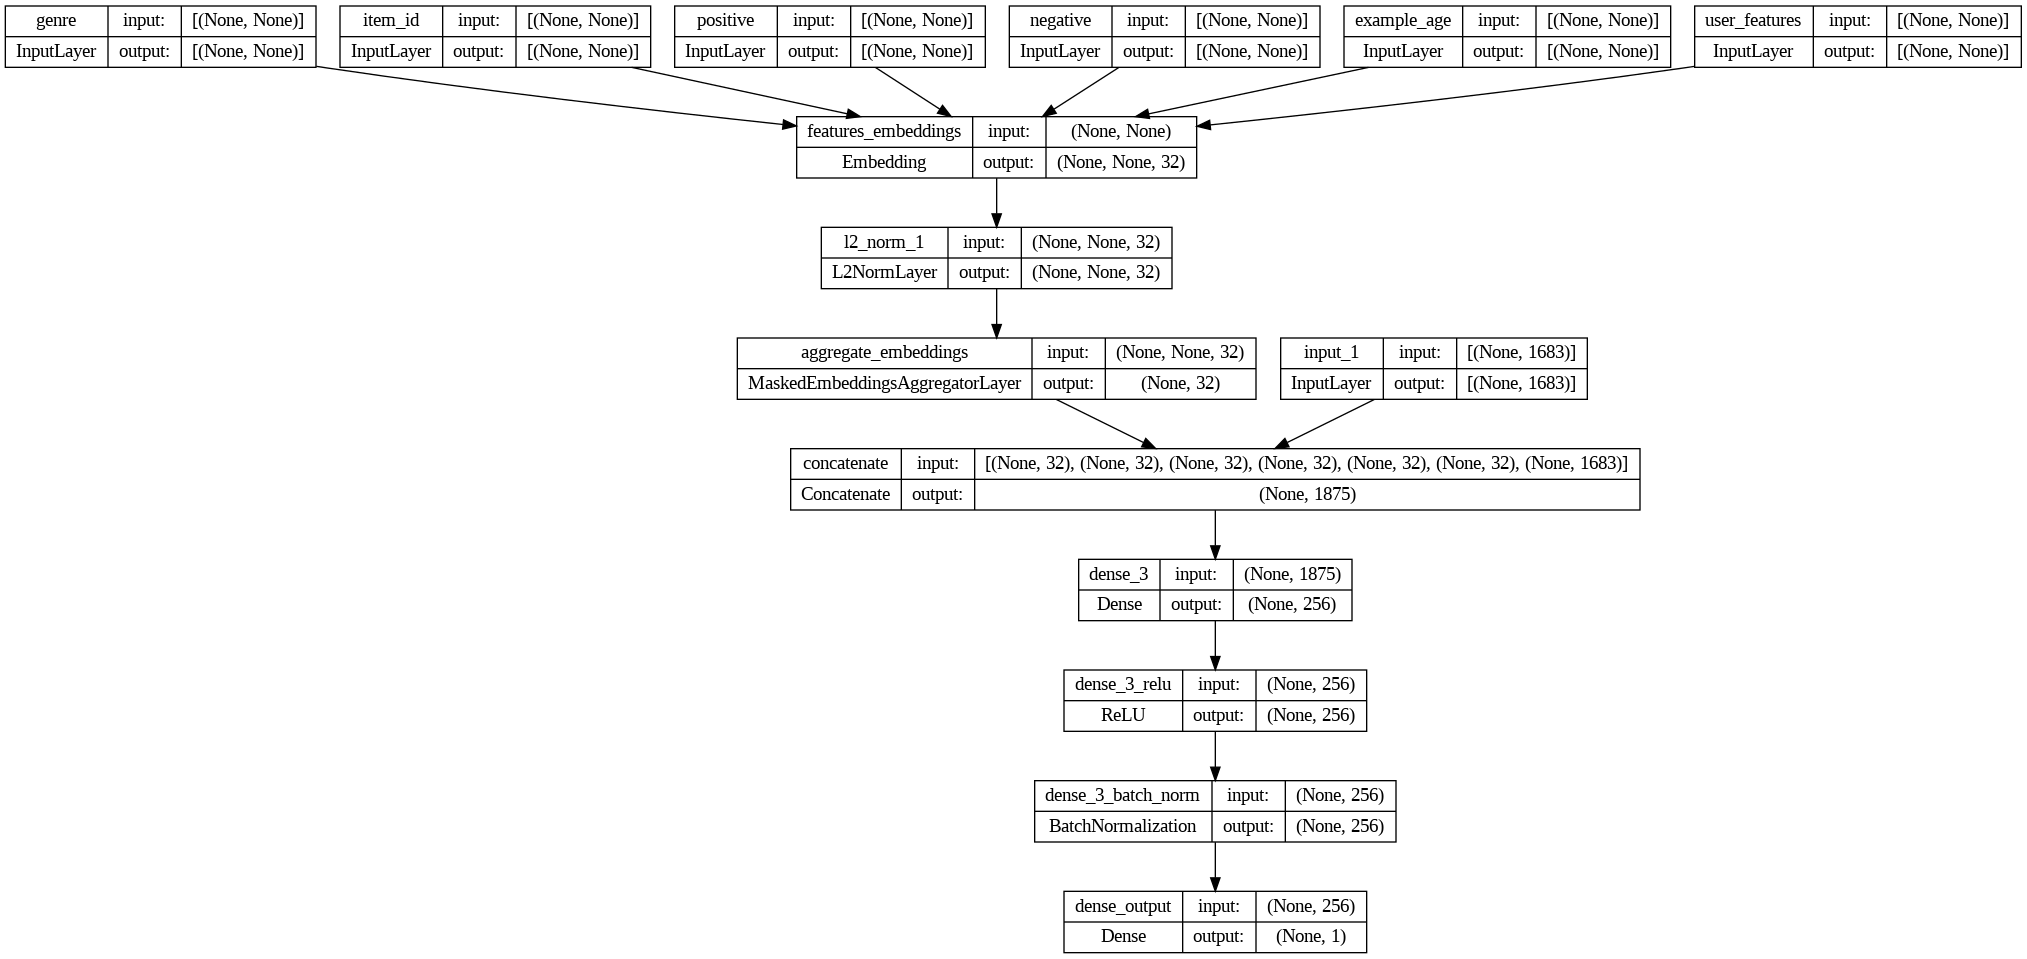

In [ ]:
embedding_dim = 32

# Compile Model
model = RankingGeneration(
    n_items=df_items.index.astype(int).max()+1, 
    embedding_dim=embedding_dim
)

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

##### **Training and hyperparameter tuning**

In [ ]:
embedding_dim = 32
history_list = {}
for lr in [0.001]:
    for reg in [0.001]:

        print(f'Start Training for lr: {lr} and reg: {reg}\n')

        # Compile Model
        model = RankingGeneration(
            n_items=df_items.index.astype(int).max()+1,
            embedding_dim=embedding_dim,
            learning_rate=lr,
            reg=reg
        )
        
        # Train model
        history = model.fit(
            x=[
                k.preprocessing.sequence.pad_sequences(train_df['genres_categorical_vector']),
                k.preprocessing.sequence.pad_sequences(train_df['item_id']),
                k.preprocessing.sequence.pad_sequences(train_df['positives']),
                k.preprocessing.sequence.pad_sequences(train_df['negatives']),
                k.preprocessing.sequence.pad_sequences(train_df['example_age']) + 1e-4,
                k.preprocessing.sequence.pad_sequences(train_df['user_features']),
                k.preprocessing.sequence.pad_sequences(train_df['next'].values)
            ], 
            y=train_df['next_label'].values,
            validation_data=([
                k.preprocessing.sequence.pad_sequences(val_df['genres_categorical_vector']),
                k.preprocessing.sequence.pad_sequences(val_df['item_id']),
                k.preprocessing.sequence.pad_sequences(val_df['positives']),
                k.preprocessing.sequence.pad_sequences(val_df['negatives']),
                k.preprocessing.sequence.pad_sequences(val_df['example_age']) + 1e-4,
                k.preprocessing.sequence.pad_sequences(val_df['user_features']),
                k.preprocessing.sequence.pad_sequences(val_df['next'].values)
            ], val_df['next_label'].values),
            callbacks=[
                k.callbacks.TensorBoard(os.path.join("logs", strftime("%Y-%m-%d %H:%M:%S")), histogram_freq=1),
                k.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
            ], 
            epochs=200, 
            verbose=1,
        )

        model.save(f'ranking_lr_{lr}_reg_{reg}.h5')

        # Save history
        history_list[f'lr_{lr}_reg_{reg}'] = history

Start Training for lr: 0.001 and reg: 0.001

Epoch 1/200
2169/2169 [==============================] - 39s 17ms/step - loss: 0.4405 - accuracy: 0.8306 - val_loss: 0.4269 - val_accuracy: 0.8258
Epoch 2/200
2169/2169 [==============================] - 36s 17ms/step - loss: 0.4001 - accuracy: 0.8397 - val_loss: 0.4185 - val_accuracy: 0.8316
Epoch 3/200
2169/2169 [==============================] - 37s 17ms/step - loss: 0.3921 - accuracy: 0.8432 - val_loss: 0.4213 - val_accuracy: 0.8273
Epoch 4/200
2169/2169 [==============================] - 35s 16ms/step - loss: 0.3888 - accuracy: 0.8425 - val_loss: 0.4222 - val_accuracy: 0.8302
Epoch 5/200
2169/2169 [==============================] - 36s 17ms/step - loss: 0.3823 - accuracy: 0.8453 - val_loss: 0.4164 - val_accuracy: 0.8316
Epoch 6/200
2169/2169 [==============================] - 35s 16ms/step - loss: 0.3773 - accuracy: 0.8464 - val_loss: 0.4188 - val_accuracy: 0.8345
Epoch 7/200
2169/2169 [==============================] - 33s 15ms/step - 

##### **Visualization**

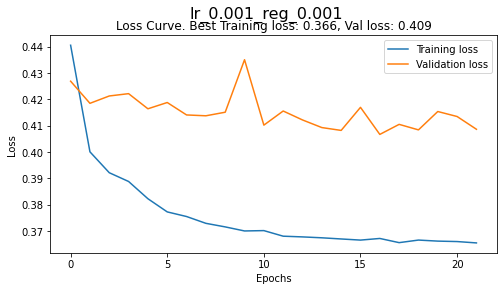

In [ ]:
for key in history_list.keys():
    plot_learning_curve(history_list[key], key)

#### **Model with the improvment**
#### Adding a fairness objective

##### **Model class**

In [ ]:
def BinaryCrossentropy_overestimation_fairness(y_true, y_pred):
    # Define a weight factor for the negative class to increase penalty for failing in that class
    weight_factor = 10.0

    # Define the cross-entropy loss for the positive class
    pos_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)

    # Define the cross-entropy loss for the negative class
    neg_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred, sample_weight=tf.where(y_true == 0, weight_factor, 1))

    # Calculate the weighted average of the two losses
    loss = tf.reduce_mean(neg_loss + pos_loss)

    return loss

In [ ]:
def RankingGeneration_impr(n_items, embedding_dim, learning_rate=1e-3, reg=1e-2):

    # Inputs
    input_genre = k.Input(shape=(None,), name='genre')
    input_item = k.Input(shape=(None,), name='item_id')
    input_positive = k.Input(shape=(None,), name='positive')
    input_negative = k.Input(shape=(None,), name='negative')
    input_example_age = k.Input(shape=(None,), name='example_age')
    input_user_features = k.Input(shape=(None,), name='user_features')
    input_current_item = k.Input(shape=(None,), name='current_item') 
    input_current_item = k.Input(shape=(None, n_items), name='current_item')

    # Embeddings
    features_embedding_layer = k.layers.Embedding(input_dim=n_items, output_dim=embedding_dim, mask_zero=True, trainable=True, name='features_embeddings')
    avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')

    # Fully connected
    dense_1 = k.layers.Dense(1024, name='dense_1', kernel_regularizer=regularizers.l2(reg))
    dense_2 = k.layers.Dense(512, name='dense_2', kernel_regularizer=regularizers.l2(reg))
    dense_3 = k.layers.Dense(256, name='dense_3', kernel_regularizer=regularizers.l2(reg))

    l2_norm_1 = L2NormLayer(name='l2_norm_1')

    dense_output = k.layers.Dense(1, tf.nn.sigmoid, name='dense_output') # n_items, softmax !!!!!!!!!111

    # Features

    # Genre
    genre_embeddings = features_embedding_layer(input_genre)
    l2_norm_genre = l2_norm_1(genre_embeddings)
    avg_genre = avg_embeddings(l2_norm_genre)

    # Ids
    item_embeddings = features_embedding_layer(input_item)
    l2_norm_item = l2_norm_1(item_embeddings)
    avg_item = avg_embeddings(l2_norm_item)

    # Positive
    positive_embeddings = features_embedding_layer(input_positive)
    l2_norm_positive = l2_norm_1(positive_embeddings)
    avg_positive = avg_embeddings(l2_norm_positive)

    # Negative
    negative_embeddings = features_embedding_layer(input_negative)
    l2_norm_negative = l2_norm_1(negative_embeddings)
    avg_negative = avg_embeddings(l2_norm_negative)

    # Example age
    example_age_embeddings = features_embedding_layer(input_example_age)
    l2_norm_example_age = l2_norm_1(example_age_embeddings)
    avg_example_age = avg_embeddings(l2_norm_example_age)

    # User features
    user_features_embeddings = features_embedding_layer(input_user_features)
    l2_norm_user_features = l2_norm_1(user_features_embeddings)
    avg_user_features = avg_embeddings(l2_norm_user_features)

    # Current item
    input_current_item = k.backend.sum(input_current_item, axis=1) # To reshape the input

    # Concatenate 
    concat_inputs = k.layers.Concatenate(axis=1)([avg_genre, avg_item, avg_positive, avg_negative, avg_example_age, avg_user_features, input_current_item])

    # Dense layers
    # Layer 1
    dense_1_features = dense_1(concat_inputs)
    dense_1_relu = k.layers.ReLU(name='dense_1_relu')(dense_1_features)
    dense_1_batch_norm = k.layers.BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

    # Layer 2
    dense_2_features = dense_2(concat_inputs)
    dense_2_relu = k.layers.ReLU(name='dense_2_relu')(dense_2_features)
    dense_2_batch_norm = k.layers.BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

    # Layer 3
    dense_3_features = dense_3(concat_inputs)
    dense_3_relu = k.layers.ReLU(name='dense_3_relu')(dense_3_features)
    dense_3_batch_norm = k.layers.BatchNormalization(name='dense_3_batch_norm')(dense_3_relu)

    outputs = dense_output(dense_3_batch_norm)

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Model
    model = tf.keras.models.Model(inputs=[input_genre, input_item, input_positive, input_negative, input_example_age, input_user_features, input_current_item], outputs=[outputs])
    model.compile(optimizer, loss=BinaryCrossentropy_overestimation_fairness, metrics=['accuracy'])
    
    return model

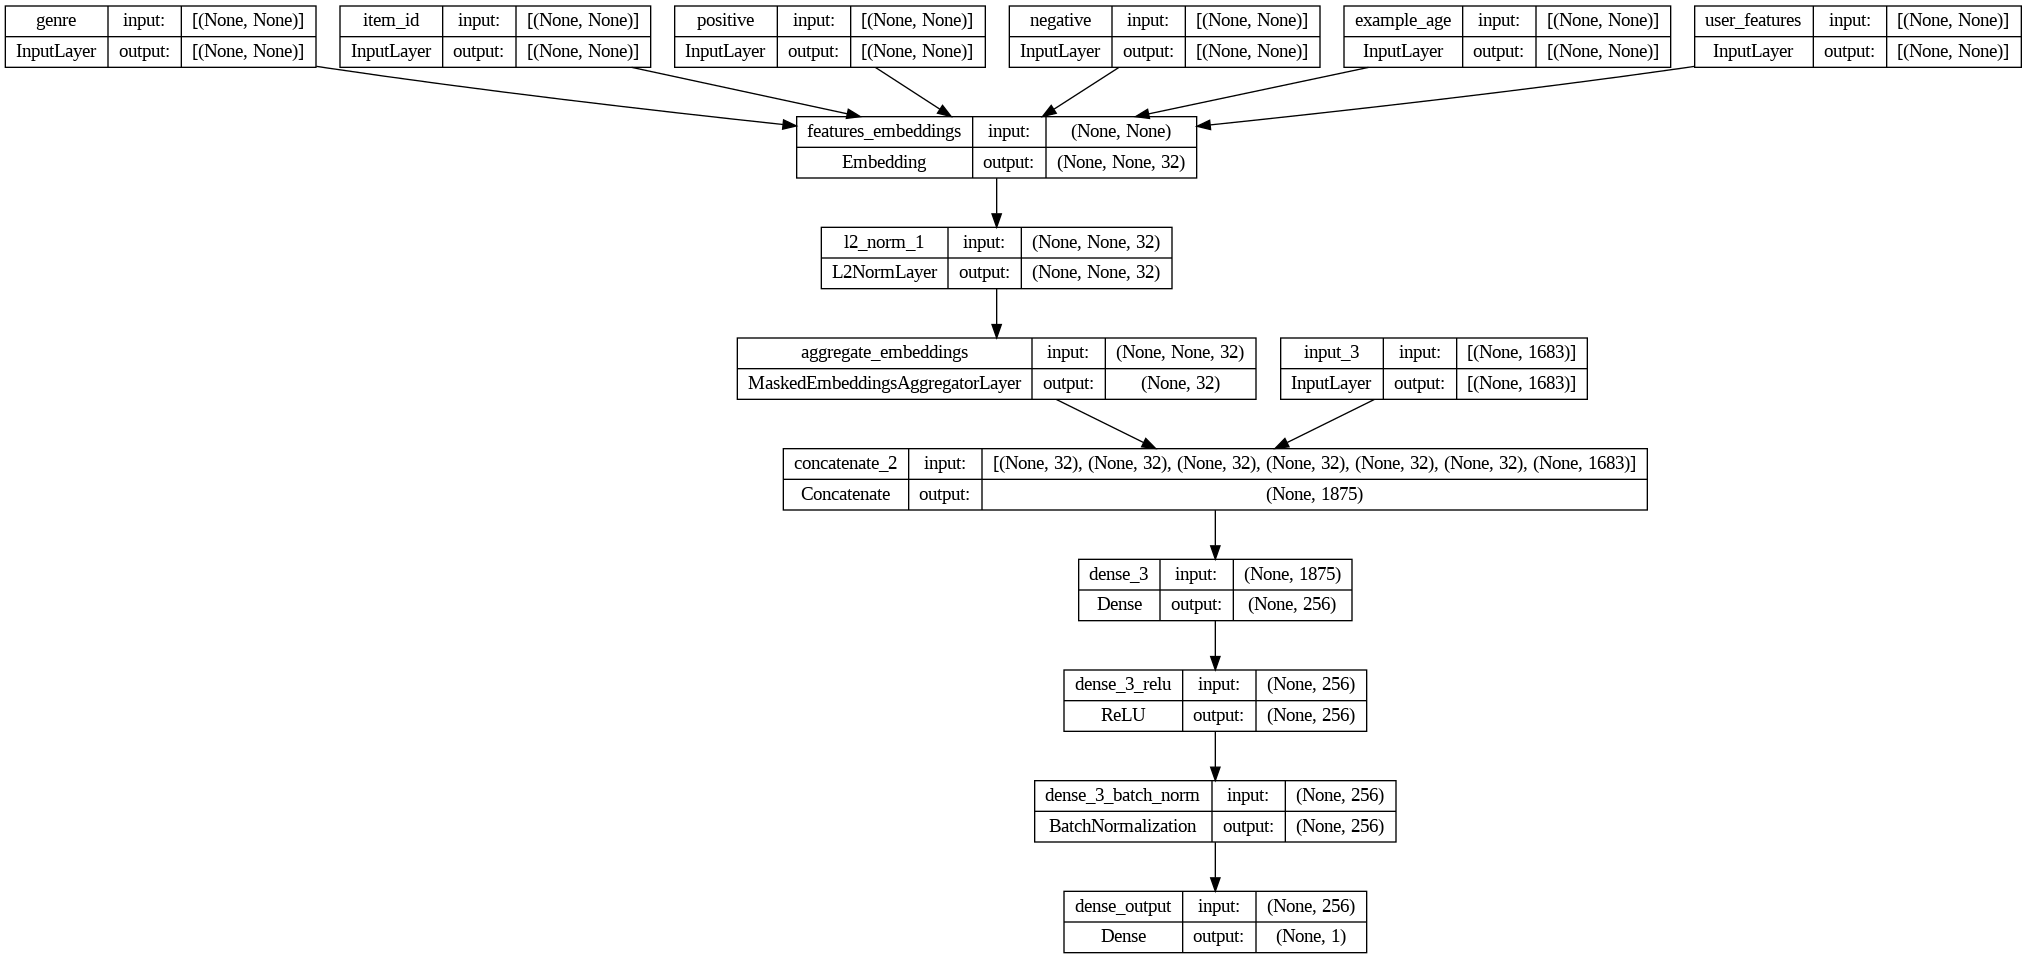

In [ ]:
embedding_dim = 32

# Compile Model
model_impr = RankingGeneration_impr(
    n_items=df_items.index.astype(int).max()+1, 
    embedding_dim=embedding_dim
)

tf.keras.utils.plot_model(model_impr, show_shapes=True, show_layer_names=True)

##### **Training with the same hyperparameter tuning**

In [ ]:
embedding_dim = 32
history_list_impr = {}
for lr in [0.001]:
    for reg in [0.001]:

        print(f'Start Training for lr: {lr} and reg: {reg}\n')

        # Compile Model
        model_impr = RankingGeneration_impr(
            n_items=df_items.index.astype(int).max()+1,
            embedding_dim=embedding_dim,
            learning_rate=lr,
            reg=reg
        )
        
        # Train model
        history = model_impr.fit(
            x=[
                k.preprocessing.sequence.pad_sequences(train_df['genres_categorical_vector']),
                k.preprocessing.sequence.pad_sequences(train_df['item_id']),
                k.preprocessing.sequence.pad_sequences(train_df['positives']),
                k.preprocessing.sequence.pad_sequences(train_df['negatives']),
                k.preprocessing.sequence.pad_sequences(train_df['example_age']) + 1e-4,
                k.preprocessing.sequence.pad_sequences(train_df['user_features']),
                k.preprocessing.sequence.pad_sequences(train_df['next']),
            ], 
            y=train_df['next_label'].values,
            validation_data=([
                k.preprocessing.sequence.pad_sequences(val_df['genres_categorical_vector']),
                k.preprocessing.sequence.pad_sequences(val_df['item_id']),
                k.preprocessing.sequence.pad_sequences(val_df['positives']),
                k.preprocessing.sequence.pad_sequences(val_df['negatives']),
                k.preprocessing.sequence.pad_sequences(val_df['example_age']) + 1e-4,
                k.preprocessing.sequence.pad_sequences(val_df['user_features']),
                k.preprocessing.sequence.pad_sequences(val_df['next']),
            ], val_df['next_label'].values),
            callbacks=[
                k.callbacks.TensorBoard(os.path.join("logs", strftime("%Y-%m-%d %H:%M:%S")), histogram_freq=1),
                k.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
            ], 
            batch_size=32,  
            epochs=200, 
            verbose=1,
        )

        model_impr.save(f'ranking_improved_lr_{lr}_reg_{reg}.h5')

        # Save history
        history_list_impr[f'lr_{lr}_reg_{reg}'] = history

Start Training for lr: 0.001 and reg: 0.001

Epoch 1/200
2169/2169 [==============================] - 38s 17ms/step - loss: 2.1718 - accuracy: 0.6692 - val_loss: 2.1891 - val_accuracy: 0.6168
Epoch 2/200
2169/2169 [==============================] - 33s 15ms/step - loss: 2.0634 - accuracy: 0.6947 - val_loss: 2.1331 - val_accuracy: 0.6792
Epoch 3/200
2169/2169 [==============================] - 32s 15ms/step - loss: 1.9927 - accuracy: 0.7079 - val_loss: 2.2307 - val_accuracy: 0.5414
Epoch 4/200
2169/2169 [==============================] - 34s 16ms/step - loss: 1.9443 - accuracy: 0.7132 - val_loss: 2.1022 - val_accuracy: 0.7199
Epoch 5/200
2169/2169 [==============================] - 33s 15ms/step - loss: 1.9209 - accuracy: 0.7193 - val_loss: 2.1044 - val_accuracy: 0.6328
Epoch 6/200
2169/2169 [==============================] - 35s 16ms/step - loss: 1.9052 - accuracy: 0.7200 - val_loss: 2.1002 - val_accuracy: 0.6880
Epoch 7/200
2169/2169 [==============================] - 33s 15ms/step - 

##### **Visualization**

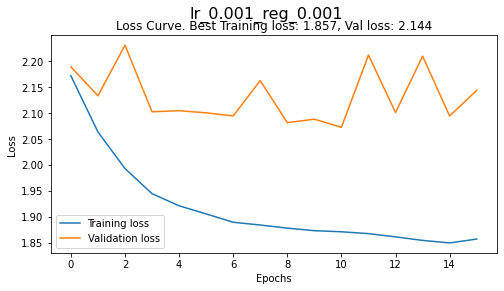

In [ ]:
for key in history_list_impr.keys():
    plot_learning_curve(history_list_impr[key], key)

#### **Models comparison**

##### **Baseline model**

In [ ]:
pred = model_mf.user_embedding.get_weights()[0].dot(model_mf.item_embedding.get_weights()[0].T)

In [ ]:
correct, cnt = 0, 0
for i, v in test_df[test_df['next_label'] == 0][['next_id']].iterrows():
    if pred[v.name - 1][v.next_id - 1] < pred[v.name - 1].mean():
        correct += 1
    cnt += 1

base_acc_0 = round(correct / cnt, 3)

correct, cnt = 0, 0
for i, v in test_df[['next_id', 'next_label']].iterrows():
    if pred[v.name - 1][v.next_id - 1] < pred[v.name - 1].mean() and v.next_label == 0:
        correct += 1
    elif pred[v.name - 1][v.next_id - 1] >= pred[v.name - 1].mean() and v.next_label == 1:
        correct += 1

    cnt += 1

base_acc = round(correct / cnt, 3)
print(f'Accuracy for all classes: {base_acc} Accuracy for class 0: {base_acc_0}')

Accuracy for all classes: 0.617 Accuracy for class 0: 0.372


##### **Original model**

In [ ]:
# Prediction
model = k.models.load_model('ranking_lr_0.001_reg_0.001.h5', custom_objects={'L2NormLayer': L2NormLayer, 'MaskedEmbeddingsAggregatorLayer': MaskedEmbeddingsAggregatorLayer})
pred = model.predict([
      k.preprocessing.sequence.pad_sequences(test_df['genres_categorical_vector']),
      k.preprocessing.sequence.pad_sequences(test_df['item_id']),
      k.preprocessing.sequence.pad_sequences(test_df['positives']),
      k.preprocessing.sequence.pad_sequences(test_df['negatives']),
      k.preprocessing.sequence.pad_sequences(test_df['example_age']) + 1e-4,
      k.preprocessing.sequence.pad_sequences(test_df['user_features']),
      k.preprocessing.sequence.pad_sequences(test_df['next'].values)
  ])) 

22/22 [==============================] - 0s 5ms/step


In [ ]:
correct, cnt = 0, 0
for i, p in enumerate(pred):
    if test_df['next_label'].values[i] == 1: continue
    cnt += 1
    p = p[0]
    if round(p) == test_df['next_label'].values[i]:
        correct += 1

original_acc_0 = round(correct / cnt, 3)

correct, cnt = 0, 0
for i, p in enumerate(pred):
    cnt += 1
    p = p[0]
    if round(p) == test_df['next_label'].values[i]:
        correct += 1

original_acc = round(correct / cnt, 3)   
print(f'Accuracy for all classes: {original_acc} Accuracy for class 0: {original_acc_0}')

Accuracy for all classes: 0.806 Accuracy for class 0: 0.343


##### **Improved model**

In [ ]:
model_impr = k.models.load_model('ranking_improved_lr_0.001_reg_0.001.h5'
              , custom_objects={
                  'L2NormLayer': L2NormLayer, 
                  'MaskedEmbeddingsAggregatorLayer': MaskedEmbeddingsAggregatorLayer, 
                  'BinaryCrossentropy_overestimation_fairness': BinaryCrossentropy_overestimation_fairness
              })

pred_impr = model_impr.predict([
        k.preprocessing.sequence.pad_sequences(test_df['genres_categorical_vector']),
        k.preprocessing.sequence.pad_sequences(test_df['item_id']),
        k.preprocessing.sequence.pad_sequences(test_df['positives']),
        k.preprocessing.sequence.pad_sequences(test_df['negatives']),
        k.preprocessing.sequence.pad_sequences(test_df['example_age']) + 1e-4,
        k.preprocessing.sequence.pad_sequences(test_df['user_features']),
        k.preprocessing.sequence.pad_sequences(test_df['next'])
  ])

22/22 [==============================] - 0s 5ms/step


In [ ]:
correct, cnt = 0, 0
for i, p in enumerate(pred_impr):
    if test_df['next_label'].values[i] == 1: continue
    cnt += 1
    p = p[0]
    if round(p) == test_df['next_label'].values[i]:
        correct += 1

impr_acc_0 = round(correct / cnt, 3)

correct, cnt = 0, 0
for i, p in enumerate(pred_impr):
    cnt += 1
    p = p[0]
    if round(p) == test_df['next_label'].values[i]:
        correct += 1

impr_acc = round(correct / cnt, 3)   
print(f'Accuracy for all classes: {impr_acc} Accuracy for class 0: {impr_acc_0}')

Accuracy for all classes: 0.69 Accuracy for class 0: 0.759


##### **All models discussion**

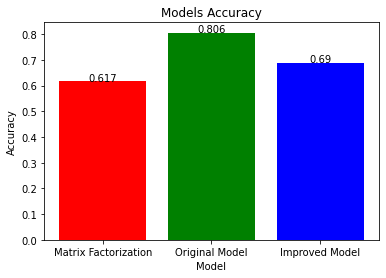

In [ ]:
width = 0.3

label = ['Matrix Factorization', 'Original Model', 'Improved Model']
acc = [base_acc, original_acc, impr_acc]
colors=['r', 'g', 'b']

plt.bar(label, acc, color=colors)

# Add the values above each bar
for i, v in enumerate(acc):
    plt.text(i, v+0.001, str(v), color='black', ha='center')

plt.title('Models Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.show()

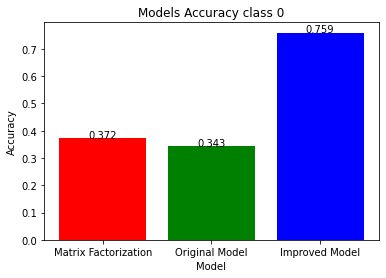

In [ ]:
width = 0.3

label = ['Matrix Factorization', 'Original Model', 'Improved Model']
acc = [base_acc_0, original_acc_0, impr_acc_0]
colors=['r', 'g', 'b']

plt.bar(label, acc, color=colors)

# Add the values above each bar
for i, v in enumerate(acc):
    plt.text(i, v+0.001, str(v), color='black', ha='center')

plt.title('Models Accuracy class 0')
plt.xlabel('Model')
plt.ylabel('Accuracy')

plt.show()